# Predicting COVID using X-Ray Imagery
### Alexander Leung

## Introduction

In this notebook, I seek to use explore how deep learning models can be used to help identify positive COVID tests. To do this, I will be using data from a 2020 [paper](https://arxiv.org/abs/2003.13145) by Chowdhury et al.

The dataset contains 15,153 labeled X-ray images in total - 3,616 are of patients with COVID-19, 10,192 of patients with 'normal' health, and 1,345 of patients with pneumonia. Since the observations are imbalanced, I will be training models on a subset of the data - 1,345 observations of each category.

There is clearly utility in exploring the use of deep learning models for identifying COVID-19 infections. Firstly, if deep learning models can successfuly identify when an individual is infected with COVID-19, then such models can be used as an effective (and perhaps, more reliable) alternative to existing methods of diagnosing the illness. Secondly, if deep learning models can successfully differentiate between COVID-19 and other respiratory diseases (such as pneumonia) using only X-ray images, then this could be useful for medical professionals when diagnosing patients. In short, such models can help to improve healthcare outcomes by speeding up the accurate delivery of treatment to sick individuals.

As this exercise is also part of a class activity, I will also be submitting the models produced to a competition hosted on the AI ModelShare platform.

*The data used in this notebooks comes from:*  
  
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

## Set-Up

### AI ModelShare

In [ ]:
! pip install aimodelshare --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/

In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


### Import and Train-Test-Split Data

In [ ]:
# connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import and unzip data
!unzip /content/drive/MyDrive/Colab\ Notebooks/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1948.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-431.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3387.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1611.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2974.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1985.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3419.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2144.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2689.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3518.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2958.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2404.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3084.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-506.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-873.png', 'COVID-19_Radiography_Dataset/COVID/images/CO

In [ ]:
# Imbalanced data - reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img

In [ ]:
# Save preprocessor function
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Convert preprocessed image data to an array rather than a list for Keras
X = np.array(preprocessed_image_data)

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Use pandas to ohe for keras
import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


In [ ]:
# Train test split resized images

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2741, 192, 192, 3), (2741, 3), (1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if runtime restarts
import pickle

# Open files and use dump()
with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

with open('X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

with open('y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

## Visualize Data

First, we can look at X-Ray images that correspond to COVID positivity, and images that do not. The first four images correspond to COVID positivity, the second four 'normal' status, and the last four pneumonia. As can be seen below, it is hard to tell the images apart with the naked eye.

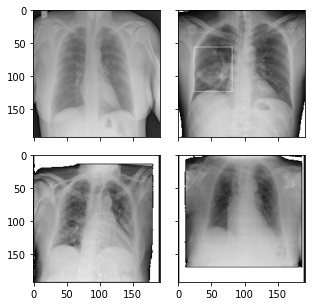

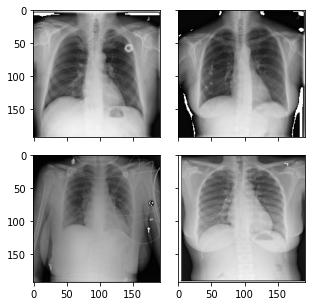

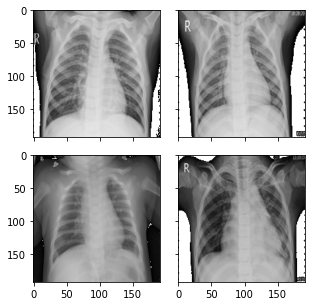

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# visualize images corresponding with covid positivity
covid_img1 = preprocessor(fnames[0][0])
covid_img2 = preprocessor(fnames[0][1])
covid_img3 = preprocessor(fnames[0][2])
covid_img4 = preprocessor(fnames[0][3])

fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),
                 axes_pad=0.25,
                 )

for ax, im in zip(grid, [covid_img1, covid_img2, covid_img3, covid_img4]):
    ax.imshow((im * 255).astype(np.uint8))
plt.show()

# visualize images corresponding with 'normal' status
normal_img1 = preprocessor(fnames[1][0])
normal_img2 = preprocessor(fnames[1][1])
normal_img3 = preprocessor(fnames[1][2])
normal_img4 = preprocessor(fnames[1][3])

fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),
                 axes_pad=0.25,
                 )

for ax, im in zip(grid, [normal_img1, normal_img2, normal_img3, normal_img4]):
    ax.imshow((im * 255).astype(np.uint8))
plt.show()

# visualize images corresponding with pneumonia
pneumonia_img1 = preprocessor(fnames[2][0])
pneumonia_img2 = preprocessor(fnames[2][1])
pneumonia_img3 = preprocessor(fnames[2][2])
pneumonia_img4 = preprocessor(fnames[2][3])

fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),
                 axes_pad=0.25,
                 )

for ax, im in zip(grid, [pneumonia_img1, pneumonia_img2, pneumonia_img3, pneumonia_img4]):
    ax.imshow((im * 255).astype(np.uint8))
plt.show()

## Model 1 - Fully-Connected Neural Network

For my first model, I decided to test how a multi-layer perceptron model would perform on the data. I used a fully-connected neural network with four hidden layers, each with 64 hidden neurons.

In [ ]:
# code to reload data in case runtime crashes
import pickle
  
# reload X_train and y-train
with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD

# set up model 1
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      sgd=SGD(learning_rate=.01)

      model1 = Sequential()
      model1.add(Dense(64,  input_shape=(192, 192, 3), activation='relu'))
      model1.add(Dense(64, activation='relu'))
      model1.add(Dense(64, activation='relu'))
      model1.add(Dense(64, activation='relu'))
      model1.add(Flatten())
      model1.add(Dense(3, activation='softmax'))

      # instantiate callback function that reduces LR if val_loss does not improve
      from tensorflow.python.keras.callbacks import ReduceLROnPlateau
      red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1)
                                                  
      # Compile model
      model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model1.fit(X_train, y_train, epochs = 15, verbose=1, validation_split=.2, callbacks = red_lr)

Epoch 1/15
69/69 [==============================] - 17s 170ms/step - loss: 0.8666 - accuracy: 0.6013 - val_loss: 0.6290 - val_accuracy: 0.7231 - lr: 0.0100
Epoch 2/15
69/69 [==============================] - 11s 157ms/step - loss: 0.5883 - accuracy: 0.7295 - val_loss: 0.5938 - val_accuracy: 0.7122 - lr: 0.0100
Epoch 3/15
69/69 [==============================] - 11s 158ms/step - loss: 0.5520 - accuracy: 0.7509 - val_loss: 0.6829 - val_accuracy: 0.7177 - lr: 0.0100
Epoch 4/15
69/69 [==============================] - 11s 159ms/step - loss: 0.4907 - accuracy: 0.7792 - val_loss: 0.4941 - val_accuracy: 0.7887 - lr: 0.0100
Epoch 5/15
69/69 [==============================] - 11s 157ms/step - loss: 0.4613 - accuracy: 0.7947 - val_loss: 0.6504 - val_accuracy: 0.6995 - lr: 0.0100
Epoch 6/15
69/69 [==============================] - 11s 158ms/step - loss: 0.4320 - accuracy: 0.8116 - val_loss: 0.4309 - val_accuracy: 0.8270 - lr: 0.0100
Epoch 7/15
69/69 [==============================] - 11s 157ms/st

In [ ]:
import pickle

# reload X_test and y_test data (if runtime crashes)  
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

In [ ]:
# evaluate model using test data
model1_score = model1.evaluate(X_test, y_test, batch_size = 128)
print(model1_score)

11/11 [==============================] - 3s 243ms/step - loss: 0.3339 - accuracy: 0.8575
[0.3338662087917328, 0.8574748039245605]


In [ ]:
# save model1 as h5 file in case runtime restarts
model1.save("model1.h5", save_format="h5")

In [ ]:
# In case runtime restarts, reload model1
import tensorflow as tf

from tensorflow.keras.optimizers import SGD
sgd=SGD(learning_rate=.01)

model1 = tf.keras.models.load_model('model1.h5',compile=False)
model1.compile(
    optimizer= sgd,
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192, 192, 64)      256       
                                                                 
 dense_1 (Dense)             (None, 192, 192, 64)      4160      
                                                                 
 dense_2 (Dense)             (None, 192, 192, 64)      4160      
                                                                 
 dense_3 (Dense)             (None, 192, 192, 64)      4160      
                                                                 
 flatten (Flatten)           (None, 2359296)           0         
                                                                 
 dense_4 (Dense)             (None, 3)                 7077891   
                                                                 
Total params: 7,090,627
Trainable params: 7,090,627
Non-

In [ ]:
# save model1 to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model1 = model_to_onnx(model1, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model1.onnx", "wb") as f:
    f.write(onnx_model1.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission
prediction_column_index1=model1.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels1 = [y_train.columns[i] for i in prediction_column_index1]

41/41 [==============================] - 6s 65ms/step


In [ ]:
# Submit model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model1.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels1)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 13

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### MLP Performance

As can be seen from the test metrics below, the MLP network model performed decently well, correctly classifying 85.75% of test observations. 

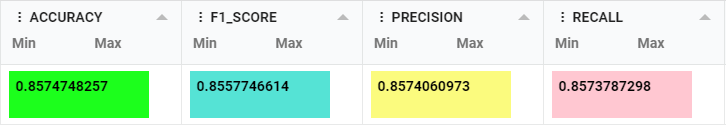

## Model 2 - Convolutional Neural Network (CNN)

Next, I decided to test how a CNN would perform on the data. I used 10 convolutional layers, with filters that gradually increased every two convolutional layers. Max pooling was used every two layers.

In [ ]:
# code to reload data in case runtime crashes
import pickle
  
# reload X_train and y-train
with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'): 
  
  # set learning rate for adam optimizer to 0.01
  adam = Adam(learning_rate = 0.001)

  model2 = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  # set callback to reduce lr when val_loss plateaus
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  # compile model2
  model2.compile(
    optimizer= adam, # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model2.fit(X_train, y_train, epochs = 15, verbose= 1, validation_split=.2, callbacks=[red_lr])

Epoch 1/15
69/69 [==============================] - 20s 121ms/step - loss: 1.1038 - accuracy: 0.3189 - val_loss: 1.0986 - val_accuracy: 0.3206 - lr: 0.0010
Epoch 2/15
69/69 [==============================] - 6s 85ms/step - loss: 1.0971 - accuracy: 0.3426 - val_loss: 1.0629 - val_accuracy: 0.6066 - lr: 0.0010
Epoch 3/15
69/69 [==============================] - 6s 90ms/step - loss: 0.7937 - accuracy: 0.6369 - val_loss: 0.6901 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 4/15
69/69 [==============================] - 6s 85ms/step - loss: 0.5992 - accuracy: 0.7427 - val_loss: 0.5256 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 5/15
69/69 [==============================] - 6s 90ms/step - loss: 0.4776 - accuracy: 0.7938 - val_loss: 0.5185 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 6/15
69/69 [==============================] - 6s 88ms/step - loss: 0.3727 - accuracy: 0.8499 - val_loss: 0.5203 - val_accuracy: 0.8033 - lr: 0.0010
Epoch 7/15
69/69 [==============================] - 6s 88ms/step - loss: 0

In [ ]:
# save model2 as h5 file in case runtime restarts
model2.save("model2.h5", save_format="h5")

In [ ]:
import pickle

# reload X_test and y_test data (if runtime crashes)  
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

In [ ]:
# evaluate model on test data
model2_score = model2.evaluate(X_test, y_test, batch_size = 128)
print(model2_score)

11/11 [==============================] - 4s 135ms/step - loss: 0.2842 - accuracy: 0.9171
[0.28423061966896057, 0.917118489742279]


In [ ]:
# In case runtime restarts, reload model2
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.001)

model2 = tf.keras.models.load_model('model2.h5',compile=False)
model2.compile(
    optimizer= adam,
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                  

In [ ]:
# save model2 to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx
onnx_model2 = model_to_onnx(model2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission
prediction_column_index2=model2.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels2 = [y_train.columns[i] for i in prediction_column_index2]

41/41 [==============================] - 7s 43ms/step


In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels2)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 14

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### CNN Performance

As can be seen from the test metrics above, given the same number of epochs, the CNN model performed better than the MLP network model, correctly classifying 91.71% of test observations.

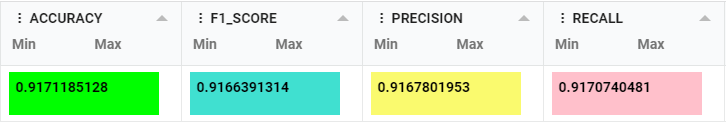

## Model 3 - Transfer Learning (ResNet)

I next decided to experiment with transfer learning methods. I used the ResNet architecture from tensorflow.keras.applications for my next model, freezing the model weights from the imagenet competition, and adding a global average pooling layer prior to classification.

In [ ]:
# code to reload data in case runtime crashes
import pickle
  
# reload X_train and y-train
with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

# Create the base model from pre-trained resnet model
base_model1 = ResNet50(input_shape= (192, 192, 3), include_top=False, weights='imagenet')

# freeze weights
base_model1.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Create new classifier layer
gap1 = GlobalAveragePooling2D()(base_model1.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)

# define new model
model3 = Model(inputs=base_model1.inputs, outputs=output)

In [ ]:
# Fit Resnet model with frozen imagenet weights and new output layer

with tf.device('/device:GPU:0'):
  
  # set lr = 0.001 for adam optimizer
  from tensorflow.keras.optimizers import Adam
  adam = Adam(learning_rate = 0.001)

  # set callback to reduce lr when val_loss plateaus
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  # compile model
  model3.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy']) 

  # fit model
  model3.fit(X_train, y_train, epochs = 15, verbose=1,validation_split=.2, callbacks = [red_lr])

Epoch 1/15
69/69 [==============================] - 13s 120ms/step - loss: 1.1012 - accuracy: 0.3440 - val_loss: 1.0888 - val_accuracy: 0.3479 - lr: 0.0010
Epoch 2/15
69/69 [==============================] - 6s 87ms/step - loss: 1.0785 - accuracy: 0.4453 - val_loss: 1.0790 - val_accuracy: 0.4499 - lr: 0.0010
Epoch 3/15
69/69 [==============================] - 6s 93ms/step - loss: 1.0699 - accuracy: 0.4288 - val_loss: 1.0573 - val_accuracy: 0.5301 - lr: 0.0010
Epoch 4/15
69/69 [==============================] - 6s 89ms/step - loss: 1.0502 - accuracy: 0.4599 - val_loss: 1.0644 - val_accuracy: 0.4117 - lr: 0.0010
Epoch 5/15
69/69 [==============================] - 6s 92ms/step - loss: 1.0368 - accuracy: 0.5078 - val_loss: 1.0367 - val_accuracy: 0.5647 - lr: 0.0010
Epoch 6/15
69/69 [==============================] - 6s 89ms/step - loss: 1.0252 - accuracy: 0.5347 - val_loss: 1.0310 - val_accuracy: 0.4791 - lr: 0.0010
Epoch 7/15
69/69 [==============================] - 6s 90ms/step - loss: 1

In [ ]:
# save model3 as h5 file in case runtime restarts
model3.save("model3.h5", save_format="h5")

In [ ]:
import pickle

# reload X_test and y_test data (if runtime crashes)  
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

In [ ]:
# evaluate model on test data
model3_score = model3.evaluate(X_test, y_test, batch_size = 128)
print(model3_score)

11/11 [==============================] - 5s 273ms/step - loss: 0.9373 - accuracy: 0.6150
[0.9372659921646118, 0.615027129650116]


In [ ]:
# In case runtime restarts, reload model3
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.001)

model3 = tf.keras.models.load_model('model3.h5',compile=False)
model3.compile(
    optimizer= adam,
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
# save model3 to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx
onnx_model3 = model_to_onnx(model3, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model3.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission
prediction_column_index3=model3.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels3 = [y_train.columns[i] for i in prediction_column_index3]

41/41 [==============================] - 5s 83ms/step


In [ ]:
# Submit model3 to Competition Leaderboard
experiment.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels3)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 15

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### ResNet Performance

Interestingly, despite its complexity, the ResNet model performed worse than both the MLP and the CNN models. The model correctly classified only 61.50% of test observations. It is possible that this is because the model was not trained over sufficient iterations - val_loss was still decreasing as of the 15th epoch. The model may perform better if it were trained over more epochs.

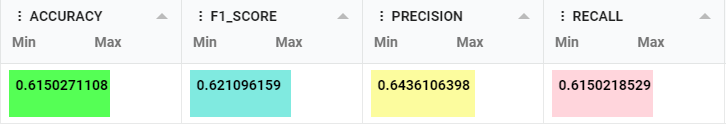

## Model 4 - Transfer Learning (VGG16)

After discussion with my groupmates, I decided next to continue exploring transfer learning methods by using other established architectures. I first used A VGG16 model, employing the same approach as the ResNet model built earlier.

In [ ]:
# code to reload data in case runtime crashes
import pickle
  
# reload X_train and y-train
with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

# create base model from pre-trained VGG16 model
base_model2 = VGG16(input_shape = (192,192,3), include_top = False, weights = 'imagenet')

base_model2.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Create new classifier layer
gap2 = GlobalAveragePooling2D()(base_model2.layers[-1].output)
output = Dense(3, activation='softmax')(gap2)

# define new model
model4 = Model(inputs=base_model2.inputs, outputs=output)

In [ ]:
# Fit VGG16 model with frozen imagenet weights and new output layer

with tf.device('/device:GPU:0'):
  
  # set lr = 0.001 for adam optimizer
  from tensorflow.keras.optimizers import Adam
  adam = Adam(learning_rate = 0.001)

  # set callback to reduce lr when val_loss plateaus
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  # compile model
  model4.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy']) 

  # fit model
  model4.fit(X_train, y_train, epochs = 15, verbose=1,validation_split=.2, callbacks = [red_lr])

Epoch 1/15
69/69 [==============================] - 13s 150ms/step - loss: 1.0605 - accuracy: 0.5128 - val_loss: 0.9469 - val_accuracy: 0.7559 - lr: 0.0010
Epoch 2/15
69/69 [==============================] - 9s 124ms/step - loss: 0.8848 - accuracy: 0.7628 - val_loss: 0.8308 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 3/15
69/69 [==============================] - 9s 124ms/step - loss: 0.7827 - accuracy: 0.7856 - val_loss: 0.7542 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 4/15
69/69 [==============================] - 9s 125ms/step - loss: 0.7144 - accuracy: 0.7838 - val_loss: 0.6920 - val_accuracy: 0.7996 - lr: 0.0010
Epoch 5/15
69/69 [==============================] - 9s 125ms/step - loss: 0.6640 - accuracy: 0.7920 - val_loss: 0.6524 - val_accuracy: 0.7923 - lr: 0.0010
Epoch 6/15
69/69 [==============================] - 7s 108ms/step - loss: 0.6258 - accuracy: 0.8038 - val_loss: 0.6183 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 7/15
69/69 [==============================] - 8s 109ms/step - l

In [ ]:
# save model4 as h5 file in case runtime restarts
model4.save("model4.h5", save_format="h5")

In [ ]:
import pickle

# reload X_test and y_test data (if runtime crashes)  
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

In [ ]:
# evaluate model on test data
model4_score = model4.evaluate(X_test, y_test, batch_size = 128)
print(model4_score)

11/11 [==============================] - 10s 409ms/step - loss: 0.4759 - accuracy: 0.8319
[0.4758608639240265, 0.8319132328033447]


In [ ]:
# In case runtime restarts, reload model4
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.001)

model4 = tf.keras.models.load_model('model4.h5',compile=False)
model4.compile(
    optimizer= adam,
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [ ]:
# save model4 to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx
onnx_model4 = model_to_onnx(model4, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model4.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission
prediction_column_index4=model4.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels4 = [y_train.columns[i] for i in prediction_column_index4]

41/41 [==============================] - 9s 144ms/step


In [ ]:
# Submit model4 to Competition Leaderboard
experiment.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels4)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 16

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### VGG16 Performance

Although the VGG16 model performed better than the ResNet model, it still performed worse than both the MLP and CNN models - it correctly classified only 83.19% of test observations. Again, this could be because the model was trained over an insufficient number of iterations - val_loss was only just beginnning to plateau at the 15th epoch (for comparison, the learning rate was decreased twice when training the CNN model).

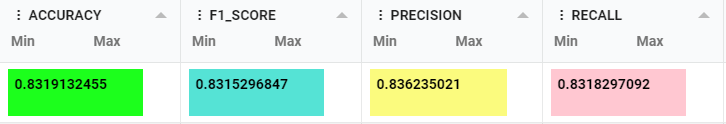

## Model 5 - Transfer Learning (Inception)

The next transfer learning approach I explored was an Inception model. I used the same approach as the previous two transfer learning models.

In [ ]:
# code to reload data in case runtime crashes
import pickle
  
# reload X_train and y-train
with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

# Create new base model from the pre-trained Inception model
base_model3 = InceptionV3(input_shape= (192, 192, 3), include_top=False, weights='imagenet')

# freeze model weights
base_model3.trainable = False

# create new classifier layer
gap3 = GlobalAveragePooling2D()(base_model3.layers[-1].output)
output = Dense(3, activation='softmax')(gap3)

# define new model
model5 = Model(inputs=base_model3.inputs, outputs=output)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Fit inception model with frozen imagenet weights and new output layer

with tf.device('/device:GPU:0'):
  
  # set lr = 0.001 for adam optimizer
  from tensorflow.keras.optimizers import Adam
  adam = Adam(learning_rate = 0.001)

  # set callback to reduce lr when val_loss plateaus
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  # compile model
  model5.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy']) 

  # fit model
  model5.fit(X_train, y_train, epochs = 15, verbose=1,validation_split=.2, callbacks = [red_lr])

Epoch 1/15
69/69 [==============================] - 16s 128ms/step - loss: 0.5859 - accuracy: 0.7432 - val_loss: 0.4231 - val_accuracy: 0.8197 - lr: 0.0010
Epoch 2/15
69/69 [==============================] - 5s 74ms/step - loss: 0.3903 - accuracy: 0.8367 - val_loss: 0.5020 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 3/15
69/69 [==============================] - 5s 67ms/step - loss: 0.3466 - accuracy: 0.8431 - val_loss: 0.3393 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 4/15
69/69 [==============================] - 5s 71ms/step - loss: 0.2919 - accuracy: 0.8773 - val_loss: 0.3349 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 5/15
69/69 [==============================] - 5s 67ms/step - loss: 0.2851 - accuracy: 0.8859 - val_loss: 0.4468 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 6/15
69/69 [==============================] - 5s 70ms/step - loss: 0.2752 - accuracy: 0.8823 - val_loss: 0.3298 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 7/15
69/69 [==============================] - 5s 72ms/step - loss: 0

In [ ]:
# save model5 as h5 file in case runtime restarts
model5.save("model5.h5", save_format="h5")

In [ ]:
import pickle

# reload X_test and y_test data (if runtime crashes)  
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

In [ ]:
# evaluate model on test data
model5_score = model5.evaluate(X_test, y_test, batch_size = 128)
print(model5_score)

11/11 [==============================] - 5s 243ms/step - loss: 0.3214 - accuracy: 0.8768
[0.32142969965934753, 0.8768396377563477]


In [ ]:
# In case runtime restarts, reload model5
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.001)

model5 = tf.keras.models.load_model('model5.h5',compile=False)
model5.compile(
    optimizer= adam,
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model5.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 95, 95, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d_10[0][0]']              
 alization)                                                                                       
                                                                                            

In [ ]:
# save model5 to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx
onnx_model5 = model_to_onnx(model5, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model5.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission
prediction_column_index5=model5.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels5 = [y_train.columns[i] for i in prediction_column_index5]

41/41 [==============================] - 6s 71ms/step


In [ ]:
# Submit model5 to Competition Leaderboard
experiment.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels5)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 17

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Inception Performance

The Inception model performed better than the VGG16, ResNet, and MLP models, correctly classifying 87.68% of test observations. However, the CNN model still outperformed the Inception model. Again, the model might improve if trained over more iterations; val_loss was beginning to plateau toward the last few epochs, but the callback to slow the learning rate had not been triggered.

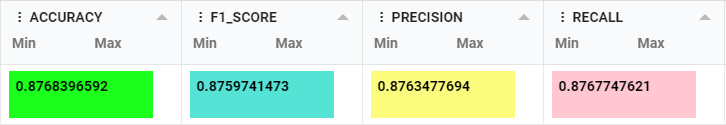

## Model 6 - Inception with Unfrozen Layers

Since the Inception model performed the best out of the three transfer learning methods tested so far, I decided to see if its performance could be boosted even further if i made the parameters in the first ten layers of the model trainable. Theoretically, this would allow the model to better adapt to the new data being fed to it from epoch to epoch, and thus have a similar effect to increasing the number of epochs over which the model was trained.

In [ ]:
# code to reload data in case runtime crashes
import pickle
  
# reload X_train and y-train
with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

# Create new base model from the pre-trained model VGG16
base_model4 = InceptionV3(input_shape= (192, 192, 3), include_top=False, weights='imagenet')

# fine tune first 20 layers, freeze all subsequent layers
freeze_layers_after = 20
for layer in base_model4.layers[freeze_layers_after:]:
  layer.trainable =  False

# create new classifier layer
gap4 = GlobalAveragePooling2D()(base_model4.layers[-1].output)
output = Dense(3, activation='softmax')(gap4)

# define new model
model6 = Model(inputs=base_model4.inputs, outputs=output)

In [ ]:
# Fit inception model with partially frozen imagenet weights and new output layer

with tf.device('/device:GPU:0'):
  
  # set lr = 0.001 for adam optimizer
  from tensorflow.keras.optimizers import Adam
  adam = Adam(learning_rate = 0.001)

  # set callback to reduce lr when val_loss plateaus
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  # compile model
  model6.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy']) 

  # fit model
  model6.fit(X_train, y_train, epochs = 15, verbose=1,validation_split=.2, callbacks = [red_lr])

Epoch 1/15
69/69 [==============================] - 22s 184ms/step - loss: 0.5787 - accuracy: 0.7614 - val_loss: 0.9913 - val_accuracy: 0.5738 - lr: 0.0010
Epoch 2/15
69/69 [==============================] - 10s 149ms/step - loss: 0.2996 - accuracy: 0.8755 - val_loss: 0.8850 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 3/15
69/69 [==============================] - 10s 143ms/step - loss: 0.2035 - accuracy: 0.9234 - val_loss: 1.0560 - val_accuracy: 0.6539 - lr: 0.0010
Epoch 4/15
69/69 [==============================] - 10s 151ms/step - loss: 0.1352 - accuracy: 0.9443 - val_loss: 0.5453 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 5/15
69/69 [==============================] - 11s 153ms/step - loss: 0.0940 - accuracy: 0.9672 - val_loss: 0.2917 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 6/15
69/69 [==============================] - 10s 148ms/step - loss: 0.0481 - accuracy: 0.9845 - val_loss: 0.3009 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 7/15
69/69 [==============================] - 10s 147ms/st

In [ ]:
# save model6 as h5 file in case runtime restarts
model6.save("model6.h5", save_format="h5")

In [ ]:
import pickle

# reload X_test and y_test data (if runtime crashes)  
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

In [ ]:
# evaluate model on test data
model6_score = model6.evaluate(X_test, y_test, batch_size = 128)
print(model6_score)

11/11 [==============================] - 2s 169ms/step - loss: 0.2180 - accuracy: 0.9380
[0.21800532937049866, 0.9380325078964233]


In [ ]:
# In case runtime restarts, reload model6
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.001)

model6 = tf.keras.models.load_model('model6.h5',compile=False)
model6.compile(
    optimizer= adam,
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model6.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_104 (Conv2D)            (None, 95, 95, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 95, 95, 32)  96          ['conv2d_104[0][0]']             
 ormalization)                                                                                    
                                                                                            

In [ ]:
# save model6 to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx
onnx_model6 = model_to_onnx(model6, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model6.onnx", "wb") as f:
    f.write(onnx_model6.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission
prediction_column_index6=model6.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels6 = [y_train.columns[i] for i in prediction_column_index6]

41/41 [==============================] - 4s 51ms/step


In [ ]:
# Submit model6 to Competition Leaderboard
experiment.submit_model(model_filepath = "model6.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels6)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 18

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Inception with Unfrozen Layers Performance

As expected, allowing the weights of the Inception model to vary significantly improved model performance, producing the best-performing model of all the architectures tested thus far - this 6th model correctly classified 93.80% of test observations.

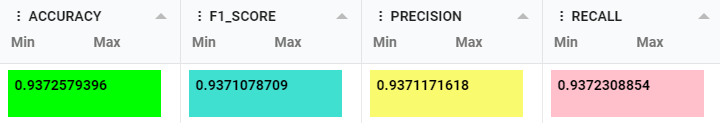

## Model 7 - Inception with Augmented Data

For my 7th and final model, I decided to see if my best-performing model could be improved any further by augmenting the data used to train it. Using Keras' ImageDataGenerator, images fed to the model were randomly either zoomed into, flipped (horizontally or vertically), or kept the same. Theoretically, this would be beneficial to the model's ultimate performance since this would artificially increase the size and variation of the data set used to train the model.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

# create list of file names
filenamelist=fnames[0]+fnames[1]+fnames[2]

# recreate y data labels made up of correctly ordered labels
from itertools import repeat
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

In [ ]:
# train test split data again, without preprocessing
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(filenamelist,
                                                   y_labels,
                                                   stratify = y_labels,
                                                   test_size = 0.32,
                                                   random_state = 1987)

In [ ]:
#Save out new train-test split in cases runtime restarts
import pickle

# Open files and use dump()
with open('X_train2.pkl', 'wb') as file:
    pickle.dump(X_train2, file)

with open('X_test2.pkl', 'wb') as file:
    pickle.dump(X_test2, file)

with open('y_train2.pkl', 'wb') as file:
    pickle.dump(y_train2, file)

with open('y_test2.pkl', 'wb') as file:
    pickle.dump(y_test2, file)

In [ ]:
# put filenames into dataframe with labels
# to facilitate augmentation using ImageDataGenerator
import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train2, 'y': y_train2})
testdata=pd.DataFrame.from_dict({'X': X_test2, 'y': y_test2})

In [ ]:
# instantiate image data generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.5,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split = .2)

test_datagen = ImageDataGenerator(rescale=1./255)

# read training data into generator
train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        subset = 'training',
        directory=None,
        x_col="X",
        y_col="y",
        target_size= (192, 192),
        class_mode='categorical',
        shuffle=True)

# create a separate generator for validation data,
# to be used when training the model
val_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        subset = 'validation',
        directory=None,
        x_col="X",
        y_col="y",
        target_size= (192, 192),
        class_mode='categorical',
        shuffle=True)

# create generator for held out test data
test_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192, 192),
        class_mode='categorical')

Found 2193 validated image filenames belonging to 3 classes.
Found 548 validated image filenames belonging to 3 classes.
Found 1291 validated image filenames belonging to 3 classes.


In [ ]:
# rerun Inception model with partially frozen layers
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

# Create new base model from the pre-trained model VGG16
base_model5 = InceptionV3(input_shape= (192, 192, 3), include_top=False, weights='imagenet')

# fine tune first 20 layers, freeze all subsequent layers
freeze_layers_after = 20
for layer in base_model5.layers[freeze_layers_after:]:
  layer.trainable =  False

# create new classifier layer
gap5 = GlobalAveragePooling2D()(base_model5.layers[-1].output)
output = Dense(3, activation='softmax')(gap5)

# define new model
model7 = Model(inputs=base_model5.inputs, outputs=output)

In [ ]:
# Fit inception model with partially frozen imagenet weights and new output layer to augmented data

with tf.device('/device:GPU:0'):
  
  # set lr = 0.001 for adam optimizer
  from tensorflow.keras.optimizers import Adam
  adam = Adam(learning_rate = 0.001)

  # set callback to reduce lr when val_loss plateaus
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  # compile model
  model7.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy']) 

  # fit model
  model7.fit(train_generator,
             steps_per_epoch = (.8 * len(trainingdata)) / 32,
             epochs = 15, 
             verbose=1,
             validation_data=val_generator,
             callbacks = [red_lr])

Epoch 1/15
68/68 [==============================] - 48s 586ms/step - loss: 0.7751 - accuracy: 0.6598 - val_loss: 0.9902 - val_accuracy: 0.5748 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - 31s 457ms/step - loss: 0.5575 - accuracy: 0.7679 - val_loss: 0.6864 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - 31s 446ms/step - loss: 0.4768 - accuracy: 0.7971 - val_loss: 0.8235 - val_accuracy: 0.6697 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - 31s 452ms/step - loss: 0.4755 - accuracy: 0.8030 - val_loss: 0.7649 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 5/15
68/68 [==============================] - 33s 473ms/step - loss: 0.4559 - accuracy: 0.8176 - val_loss: 0.5479 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - 31s 445ms/step - loss: 0.4155 - accuracy: 0.8354 - val_loss: 0.7659 - val_accuracy: 0.6880 - lr: 0.0010
Epoch 7/15
68/68 [==============================] - 31s 446ms/st

In [ ]:
# save model7 as h5 file in case runtime restarts
model7.save("model7.h5", save_format="h5")

In [ ]:
# evaluate model on test_generator data
model7_score = model7.evaluate(test_generator, batch_size = 128)
print(model7_score)

41/41 [==============================] - 5s 123ms/step - loss: 0.2588 - accuracy: 0.9001
[0.2587527334690094, 0.9000774621963501]


In [ ]:
# also evaluate model on X_test data - check if there is any difference
model7_score = model7.evaluate(X_test, y_test, batch_size = 128)
print(model7_score)

11/11 [==============================] - 4s 163ms/step - loss: 0.2417 - accuracy: 0.9086
[0.24168607592582703, 0.908598005771637]


In [ ]:
# In case runtime restarts, reload model7
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.001)

model7 = tf.keras.models.load_model('model7.h5',compile=False)
model7.compile(
    optimizer= adam,
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model7.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_198 (Conv2D)            (None, 95, 95, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 95, 95, 32)  96          ['conv2d_198[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
# save model7 to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx
onnx_model7 = model_to_onnx(model7, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model7.onnx", "wb") as f:
    f.write(onnx_model7.SerializeToString())

In [ ]:
import pickle

# reload X_test data (if runtime crashes)  
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission
prediction_column_index7=model7.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels7 = [y_train.columns[i] for i in prediction_column_index7]

41/41 [==============================] - 2s 52ms/step


In [ ]:
# Submit model7 to Competition Leaderboard
experiment.submit_model(model_filepath = "model7.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels7)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 19

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Inception with Augmented Data Performance
Interestingly, though the model with augmented data performed better than the MLP, ResNet, and VGG16 architectures, it performed worse than the Inception model without augmented data, and worse than the CNN network - it correctly classified 90.86% of held out test observations.

This is perhaps not entirely unexpected. Since the model was trained using the same number of epochs as the other models tested thus far, this means that the total amount of training data seen by this 7th model is the *same* as that seen by the other models. At the same time, the variance in the training data has increased - while the raw data has a fairly uniform appearance (see the visualizations produced earlier in this notebook) the flipped and zoomed-into augmented data will appear quite distinct. There is litle reason to suspect that the model would perform better on a dataset that is of the same size, but that has more variance in the data. The benefits of data augmentation might be more visible if the model were trained on a larger absolute quantity of data - i.e., increasing the number of epochs over which the model is trained.

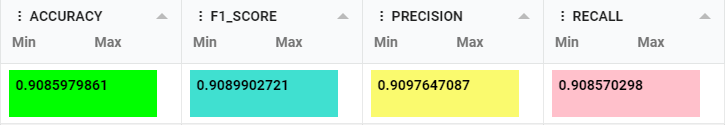

## Conclusion

In summary, in this notebook, I explored using deep learning architectures (MLP, CNN, ResNet, VGG16, and Inception) to predict COVID positivity from X-ray images of patients' lungs. This exercise has demonstrated that such methods may be a viable means of detecting COVID-19 - a model based on the Inception architecture was able to correctly classify COVID-19 cases for 93.80% of held-out test data.

Interestingly, two of the three transfer learning methods I explored (ResNet and VGG16) performed worse than the fairly simple MLP and CNN models employed. This is likely due to the fact that the models were only trained over a relatively small number of epochs (15) - further training might have seen better results. The Inception model also interestingly performed worse when trained on augmented data, though again this is likely because of the fact that the model only received a limited amount of training. Increasing the number of epochs that each model is trained for (and training these models on augmented data) could be a viable direction for further exploration, and lead to improvement of model performance.